View differences in interpolation with OPM deskew and pyclesperanto deskew. 
Need to write tests, so working out the best way to do this. 

In [2]:
#OPM implementation
#need numba installed

import numpy as np
from numba import njit, prange

   
# http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
@njit(parallel=True)
def deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    return output

TRY OPM DESKEW

In [3]:
source = np.zeros((10, 10, 10))
source[1, 1, 1] = 1

result = deskew(source,theta = 30, distance = 1, pixel_size = 1)
result.shape

(5, 19, 10)

Find positions in array where result>0

In [4]:
np.where(result>0)

(array([1], dtype=int64), array([2], dtype=int64), array([1], dtype=int64))

TRY pyclesperanto deskew

In [5]:
import pyclesperanto_prototype as cle 

cle_result = cle.deskew_y(source,angle_in_degrees=30,voxel_size_x=1,voxel_size_y=1,voxel_size_z=1)
cle_result.shape

(5, 19, 10)

In [6]:
np.where(cle_result>0)

(array([0, 0], dtype=int64),
 array([1, 2], dtype=int64),
 array([1, 1], dtype=int64))

In [11]:
print(cle_result[0,1,1])
print(cle_result[0,2,1])

0.43301263
0.16506355


In [15]:
print("We get different results with pyclesperanto and OPM deskew. Not sure if this is a difference due to algorithmic implementation or differences in CPU/GPU implementation?")

We get diffferent results with pyclesperanto and OPM deskew. Not sure if this is a difference due to algorithmic implementation or differences in CPU/GPU implementation?


### Use a test image and  a metric such as structure similarity index measure to compare the results

In [16]:
from skimage.io import imread
original_image = imread('../../data/RBC_tiny.tif')
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30
original_image.shape


(834, 118, 209)

In [18]:
cle_rbc = cle.deskew_y(original_image,angle_in_degrees=deskewing_angle_in_degrees,voxel_size_x=voxel_size_x_in_microns,
                          voxel_size_y=voxel_size_y_in_microns,voxel_size_z=voxel_size_z_in_microns)

cle_rbc.shape

(59, 1828, 209)

In [19]:
opm_rbc = deskew(original_image,theta = deskewing_angle_in_degrees, distance = voxel_size_z_in_microns,
                 pixel_size = voxel_size_y_in_microns)
opm_rbc.shape

(59, 1828, 209)

In [35]:
from skimage.metrics import structural_similarity

mssim,s_img = structural_similarity(cle_rbc, opm_rbc,full=True)

#Subtract images to see differences
diff_img = cle_rbc - opm_rbc

Mean SSIM:  0.8292349569424358


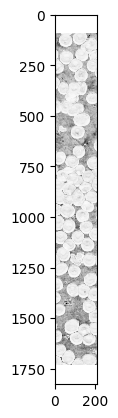

In [27]:
print("Mean SSIM: ", mssim)
cle.imshow(s_img)

In [36]:
import napari 

viewer = napari.Viewer()
viewer.add_image(cle_rbc, name='cle_rbc')
viewer.add_image(opm_rbc, name='opm_rbc')
viewer.add_image(s_img, name='SSIM_img')
viewer.add_image(diff_img, name='diff_img')


<Image layer 'diff_img' at 0x230b3731fd0>